## Demonstrating the Use of Autoencoders for Feature Extraction

Autoencoders are a rather interesting type of model. Rather than the conventional supervised/unsupervised learning paradigms, autoencoders are self-supervised. They perform learning on the unlabeled dataset, in order to learn transformations to that dataset for achieving particular goals. In this notebook, I explore the use of a convolutional autoencoder for transforming the MNIST dataset from $28 \times 28 \times 1$ to $7 \times 7 \times 1$, and demonstrate an identical convolutional neural network classifier (with the exception of the input shape) to perform multi-class classification on both the original and the encoded dataset to show the performance impacts of using an autoencoder for reduction of feature space.

## Imports

In the following cell, all necessary imports are included into the notebook, and any additional global-level setup for the jupyter environment are performed.

* **`requests`:** used for disabling the any request warnings when extracting the MNIST dataset through the SSL API. Used for cleaner display during runtime.
* **`numpy`:** used for matrix transformations for the dataset, including reshaping among other uses. 
* **`matplotlib.pyplot`:** used for plotting the learning curves and displaying the images within the notebook output cells
* **`seaborn`:** used for generating a stylized heatmap for the confusion matrix from the results generated by the neural networks.
* **`matplotlib.gridspec`:** another matplotlib import that is used as a container for displaying the seaborn confusion matrix.
* **`tensorflow.keras`:** used for any operations involving the neural network
* **`tensorflow`:** though we are working exclusively within keras (which is imported separately for better readability of the neural network operations), tensorflow is imported separately in order to configure the gpu environment to use GPU 0 without the memory growth limit (utilize the GPU to its fullest potential). GPU 0 is an NVIDIA RTX 2070 on the development environment. 

Next, we perform the GPU environment setup. We first get a list of the available GPU devices in the system which tensorflow is capable of utilizing. Then we select the first available GPU (GPU $0$), and set it to use the experimental growth, which disables any limitations on the memory size besides the physical limit to the number of cores in the GPU. 

And finally, we configure the matplotlib environment for the notebook. We first specify that the plot use the `ggplot` style, which I personally find to be more visually appealing for readability of the learning curves. It is set to become the default display of all other plots in the notebook. Finally, using line magic `%%matplotlib`, we tell the notebook to display any plots/figures/subplots inline within the notebook's output cell (without the use of `plt.show()` and without any matplotlib object descriptions in the output window -- overall a cleaner display). 

In [1]:
# === Imports === #
import requests
import ssl
import numpy               as np
import matplotlib.pyplot   as plt
import seaborn             as sns
import matplotlib.gridspec as gridspec
from   tensorflow          import keras


# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices( 'GPU' )
tf.config.experimental.set_memory_growth( physical_devices[0] , True )

# === Total Times Log === #
plt.style.use( 'ggplot' )
%matplotlib inline

## Setup SSL for Retrieving MNIST

Rather than using a copy of the MNIST dataset stored in a local directory, since I intend to use the same dataset for multiple future projects, we will instead extract the dataset if needed, and have it stored within the keras datasets. The below cell prepares the SSL configurations for retrieving the dataset over the internet (SSL) if needed. 

In [2]:
# === Disable MNIST SSL Warning === #
requests.packages.urllib3.disable_warnings( )

# === Get the MNIST Dataset === #
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass  # legacy handling, modern python always verifies HTTPS by default now
else:
    ssl._create_default_https_context = _create_unverified_https_context  # if env doesnt support https

## Import MNIST into Memory

In the below cell, we begin by extracting the mnist dataset from keras (downloading through SSL if needed). Once mnist is loaded into memory, we parse out the training and testing datasets/labels. We extract data on the dimensions of the dataset for reporting later, we reshape to add an additional color channel (even though MNIST is grayscale, keras dislikes when there is no color channel dimension on grayscale images). We then perform regularization on the dataset. By dividing all values in the images by $255$, we force the grayscale images to hold values between $0$ and $1$, which allows the neural networks to better learn the data. Finally, we report some of the information on the simensions of the dataset in order to confirm that the data has been loaded successfully. 

In [3]:
# === Load MNIST through Keras === #
mnist             = keras.datasets.mnist.load_data( path='mnist.npz' )
X_train , y_train = mnist[0]
X_test  , y_test  = mnist[1]

# === Dimension Data === #
h = X_train.shape[1]
w = X_train.shape[2]
a = w * h

# === Add Color Channel to Prevent Errors === #
X_train = X_train.reshape( X_train.shape[0] , w , h , 1 )
X_test  = X_test.reshape( X_test.shape[0] , w , h , 1 )

# === Perform Regularization on the Data === #
X_train = X_train.astype( np.float32 ) / 255.
X_test  = X_test.astype( np.float32 ) / 255.

# === Give Indication that Load Completed === #
print( 'MNIST Loaded' )
print( 'Training Parition: {}'.format( X_train.shape ) )
print( 'Testing Partition: {}'.format( X_test.shape  ) )
print( 'Feature Space (Per Image): {} x {} --> {} features'.format( w , h , a ) )

MNIST Loaded
Training Parition: (60000, 28, 28, 1)
Testing Partition: (10000, 28, 28, 1)
Feature Space (Per Image): 28 x 28 --> 784 features


## Visualize the Dataset

In this cell, we will define a function to plot a random sample of the numerals within the dataset. We know that the MNIST dataset contains nearly the same number of each digit $(0-9)$, so we randomly select one data value of each digit to be displayed in the output cell. This is intended to provide a better visualization of the working dataset for anyone who may be unfamiliar with the data, or having issues with visualizing what the matrices stored represent. 

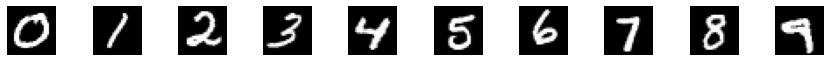

In [4]:
def sample_plot( X , y ):
        
    # === Show the Images === #
    fig, ax = plt.subplots( nrows=1 , ncols=10 , figsize=( 12 , 3 ) )
    fig.tight_layout( )
    
    # === Populate Axes === #
    for i in range( 10 ):
        idx = np.random.choice( np.where( y==i )[0] )
        ax[i].imshow( X[idx] , cmap='gray' )
        ax[i].axis( 'off' )
        
    # === Show Figure === #
    return

sample_plot( X_train , y_train )

## Create a Classifier Model For Raw Image Input

The `create_model()` function was written to the produce and return a `keras.Sequential` object configured to be a simple, shallow convolutional neural network which consists of two convolution blocks.

The first convolution block starts with a 2D-Convolution with $32$ filters on a $3 \times 3$ kernel with the Rectified Linear Unit (ReLU) activation function. The results are then passed through Batch Normalization. The normalized results are then fed through a $2 \times 2$ Max Pooling layer. The pooling results finally have a $10\%$ dropout.

The second convolution block follows a similar path as the first. It begins with a 2D-Convolution with $64$ filters on a $3 \times 3$ kernel with the ReLU activation function. The results of the convolution are passed through Batch Normalization. The normalized results are then passed thorugh a $2 \times 2$ Max Pooling layer. The results of the pooling layer are then passed into another $10\%$ dropout.

Finally, the results are flattened from a matrix into a vector. The vector passes through a fully-connected (dense) layer, which contains one node for each of the $10$ classes (digits) with the ReLU activation function again, and finally, a single-node output layer which uses the softmax activation function to produce the predicted class. 

In [5]:
def create_model( input_shape , n_classes ):
    
    # === Create Object === #
    model = keras.Sequential( )
    
    # === Input Layer === #
    model.add( keras.Input( input_shape , name='Input' ) )
    
    # === Convolution Block 1 === #
    model.add( keras.layers.Conv2D( 32 , kernel_size=(3,3) , padding='same' , activation='relu' ) )
    model.add( keras.layers.BatchNormalization( ) )
    model.add( keras.layers.MaxPooling2D( (2,2) ) )
    model.add( keras.layers.Dropout( 0.1 ) )
    
    # === Convolution Block 2 === #
    model.add( keras.layers.Conv2D( 64 , kernel_size=(3,3) , padding='same' , activation='relu' ) )
    model.add( keras.layers.BatchNormalization( ) )
    model.add( keras.layers.MaxPooling2D( (2,2) ) )
    model.add( keras.layers.Dropout( 0.1 ) )
    
    # === Return Model === #
    model.add( keras.layers.Flatten( ) )
    model.add( keras.layers.Dense( n_classes , activation='softmax' ) )
    return model

## Compile the Model

Now that we have a function defined for creating the model object, we will use that function to create the classifier for our MNIST dataset. For the purposes of this demonstration, we will be using the `adam` optimizer, Sparse Categorical Crossentropy for the loss function, and we will also be evaluating the Accuracy during training. We will compile the model constructed, and print out a summary of that model to verify that it has been successfully compiled without any issues. 

In [6]:
raw_model = create_model( X_train[0].shape , 10 )
raw_model.compile( optimizer='adam' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'] )
raw_model.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

## Prepare the Callbacks for Training the Model

We will define some additional callbacks before we begin training the model. Thare are three that we are interested in for the purposes of this demonstration:

1. **Early Stopping:** If the validation loss does not decrease for $10$ consecutive epochs, stop training early (the model has either converged or overfit)
2. **Reduce on Plateau:** reduce the learning rate by a factor of $0.1$ if the validation loss does not decrease for four consecutive epochs (decrease the learning rate when learning slows down in a hope to stimulate a finer granularity of learning).
3. **Model Checkpoint:** every time the validation loss decreases, save an updated version of the weights (save the best model during learning). 

In [7]:
raw_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss' , mode='min' , patience=10 , verbose=1 ),
    keras.callbacks.ReduceLROnPlateau( factor=0.1 , patience=4 , min_lr=0.000001 , verbose=1 ),
    keras.callbacks.ModelCheckpoint( 'raw-classifier-model.h5' , monitor='val_loss', mode='min' , verbose=1 , save_best_only=True , save_weights_only=True )
]

## Train the Model

Finally, we will train the convolutional neural network classifier (without the use of an autoencoder) to establish baseline performance for classification. We will train using our unaltered training and validation datasets, a batch size of $32$, and a maximum of $100$ epochs (which may terminate sooner due to early stopping). We see consistently that the model is able to achieve a validation accuracy greater than $99\%$ consistently (usually $99.2\%$). 

In [8]:
raw_history = raw_model.fit( X_train, 
                             y_train, 
                             batch_size=32, 
                             epochs=100, 
                             callbacks=raw_callbacks,
                             validation_data=( X_test , y_test ) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
59808/60000 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9576
Epoch 00001: val_loss improved from inf to 0.05694, saving model to raw-classifier-model.h5
60000/60000 [==============================] - 7s 123us/sample - loss: 0.1539 - accuracy: 0.9576 - val_loss: 0.0569 - val_accuracy: 0.9840
Epoch 2/100
59616/60000 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9810
Epoch 00002: val_loss did not improve from 0.05694
60000/60000 [==============================] - 6s 95us/sample - loss: 0.0750 - accuracy: 0.9809 - val_loss: 0.0669 - val_accuracy: 0.9823
Epoch 3/100
59808/60000 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9851
Epoch 00003: val_loss improved from 0.05694 to 0.05176, saving model to raw-classifier-model.h5
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0575 - accuracy: 0.9851 - val_loss: 0.0518 - val_accuracy: 

## Plot the Learning Curves

Now that training the classifier on the raw dataset (no autoencoder), let's take a moment to better visualize the learning. The cell below defines a function which plots loss and accuracy side-by-side into the output window for the cell given the model history (return value of `model.fit()`). We then use the function to plot the formatted learning curves together for the recently-obtained learning history `raw_history`, as well as display a red X on each of the two plots based on which checkpoint we will be using for the model.

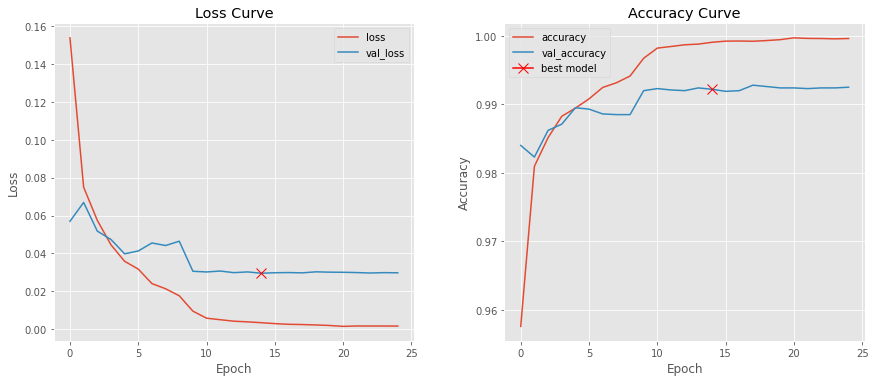

In [9]:
def plot_learning( history ):
    
    # === Setup the Figure === #
    fig, ax = plt.subplots( nrows=1 , ncols=2 , figsize=(12,5) )
    fig.tight_layout( )
    fig.subplots_adjust( wspace=0.25 )
    
    # === Loss Curve === #
    ax[0].title.set_text( 'Loss Curve' )
    ax[0].set_xlabel( 'Epoch' )
    ax[0].set_ylabel( 'Loss' )
    ax[0].plot( history.history['loss'] , label='loss' )
    ax[0].plot( history.history["val_loss"] , label="val_loss" )
    ax[0].legend( )
    ax[0].plot( np.argmin( history.history["val_loss"] ), 
                np.min( history.history["val_loss"] ), 
                marker="x", 
                color="r",
                ms=10,
                label="best model" )
    
    # === Accuracy Curve === #
    ax[1].title.set_text( 'Accuracy Curve' )
    ax[1].plot( history.history['accuracy'] , label='accuracy' )
    ax[1].plot( history.history['val_accuracy'] , label="val_accuracy" )
    ax[1].plot( np.argmin( history.history["val_loss"] ), 
                history.history['val_accuracy'][np.argmin( history.history["val_loss"] )], 
                marker="x", 
                color="r",
                ms=10,
                label="best model" )
    ax[1].set_xlabel( "Epoch" )
    ax[1].set_ylabel( "Accuracy" )
    ax[1].legend( )
    
plot_learning( raw_history )

## Reload the Weights of the Best Model

The weights of the model when the training completed are not necessarily the best model we want to use. We may have found early-stopping due to overfitting. To ensure we are using the best model going forward, we will be using the weights saved in the most recent model checkpoint (as defiend in the model's callbacks). We will restore these weights for use in all future operations.

In [10]:
# === Load Most Recent Checkpoint === #
raw_model.load_weights( 'raw-classifier-model.h5' )

## Evaluate the Best Model

In order to verify the performance of the model we will be using, we want to use Keras's built-in evaluate function in order to extract the validation loss and accuracy of the model with the weights we loaded. We will specify that the function is verbose in order to display a progress bar during the evaluation. 

In [11]:
# === Evaluate the Model Against the Test Dataset === #
print( 'Evaluating Model on Test Set...' )
_ = raw_model.evaluate( X_test , y_test , verbose=True )

Evaluating Model on Test Set...
10000/10000 [==============================] - 0s 43us/sample - loss: 0.0295 - accuracy: 0.9922


## Demonstrate the Classification in Action

Though some may be convinced at the performance of the model by simply observing the loss and accuracy values of the model on the validation (test) dataset. Others may remain unconvinced. To help solidify the strength of the classification, a helper function is written and called to yet-again select one random image for each (image) class in the dataset, label the ground truth and the model's prediction, and display visually how effective the model is. 

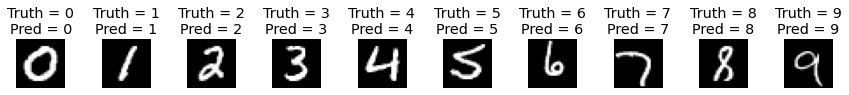

In [12]:
def demo_model( X , y , model ):
    # === Show the Images === #
    fig, ax = plt.subplots( nrows=1 , ncols=10 , figsize=(12,3) )
    fig.tight_layout( )
    
    # === Populate Axes === #
    for i in range( 10 ):
        idx = np.random.choice( np.where( y==i )[0] )
        ax[i].imshow( X[idx] , cmap='gray' )
        ax[i].axis( 'off' )
        ax[i].title.set_text( 'Truth = {}\nPred = {}'.format( i , np.argmax( model.predict( X[idx].reshape( (1,) + X[idx].shape ) ) ) ) )
        
    # === Show Figure === #
    return

demo_model( X_test , y_test , raw_model )

## Model Confusion Matrix

Finally, we will define one more visualization function which produces a confusion matrix for the dataset, and uses seaborn paired with matplotlib for visualizing the confusion matrix with formatted display. 

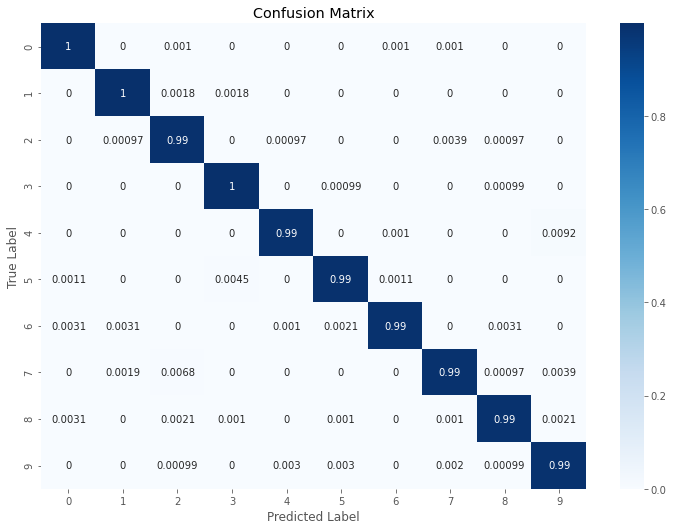

In [13]:
def show_confusion_matrix( X , y , model ):
    
    # === Get the Confusion Matrix === #
    y_pred = np.argmax( model.predict( X ) , axis=-1 )
    mat    = tf.math.confusion_matrix( labels=y , predictions=y_pred ).numpy( ).astype( np.float32 )
    
    # === Normalize the Matrix by Class === #
    for row in range( len( mat ) ):
        mat[row] = mat[row] / mat[row].sum( )
    
    # === Plot === #
    plt.figure( figsize=(10,7) )
    sns.heatmap( mat , annot=True , cmap=plt.cm.Blues )
    plt.tight_layout( )
    plt.title( 'Confusion Matrix' )
    plt.ylabel( 'True Label' )
    plt.xlabel( 'Predicted Label' )
    
show_confusion_matrix( X_test , y_test , raw_model )

## Convolutional Autoencoder

Now that we have built and trained a classifier which is capable of achieving sufficiently well for digit classification on the MNIST dataset, let's build an autoencoder in an attempt to retain the model performance while using a significantly reduced feature space. The original MNIST dataset is $28 \times 28 = 784$ features in size. The results of encoding the dataset will produce $7 \times 7 = 49$ features (a 93% reduction in the number of features). Let's train the autoencoder by convoluting the input down do a reduced size, then using transpose convolutions to restore the original dimensions. The design of the autoencoder is to take the original input image/dataset, encode it down to the desired size, then decode it back up to the original size within the same training session. The reason why this neural network is a convolutional autoencoder is because the entire encoding and decoding process is obtained using convolutions and transpose convolutions instead of fully-connected dense layers. 

The autoencoder consists of two convolution blocks, the final encoded layer, then two deconvoltuion blocks to "undo" the initial convolutions.

The first convolution consists of a 2D-Convolution layer with $32$ filters on a $3 \times 3$ kernel with the ReLU activation function. The results of the convolution undergo Batch Normalization, then Max Pooling on a $2 \times 2$ pool, and finally, a $10\%$ dropout. 

The second convolution block is nearly identical to the first. It consists of a 2D-convolution layer with $64$ filters on a $3 \times 3$ kernel with the ReLU activation function. The results of the convolution undergo Batch Normalization, then Max Pooling on a $2 \times 2$ pool, and finally, a $10\%$ dropout. 

The final layer wihich produces the encoding is a single 2D convolution layer with $1$ filter on a $3 \times 3$ kernel with the ReLU activation function. The output shape of this layer will be $7 \times 7 \times 1$ when using an input of the shape specified for MNIST ($28 \times 28 \times 1$.

The first Decoding (transpose convolution) block is similar to its corresponding convolution block (convolution block 2). It first performs a 2D-Transpose Convolution with $64$ filters on a $3 \times 3$ kernel with the ReLU activation function. The results are then passed through Batch Normalization, then $2 \times 2$ 2D Upsampling, and finally, a $10\%$ dropout. 

The final Decoding (transpose convolution) block is similar to its corresponding convoltuion block (convolution block 1). It first performs a 2D-Transpose Convolution with $32$ filters on a $3 \times 3$ kernel with the ReLU activation function. The results are then passed through Batch Normalization, then $2 \times 2$ Upsampling, and finally, a $10\%$ dropout. 

Finally, the "depth" of the output shape must be reduced back to $1$ (to match the number of color channels and to fully undo the final encoded layer). This is done using a 2D-Transpose Convolution on a single filter and a $3 \times 3$ kernel with the Sigmoid activation function. This layer is treated as the model's output layer, and the expected output shapeshould be identical to the input shape (as long as both input dimensions are a multiple of $4$, since each of the two pooling layers will round down odd numbered dimensions). For MNIST, this is fine, since each dimension is a multiple of $4$ in the original dataset. 

The below function `create_autoencoder()` will produce a `keras.Sequential` model object to be used for training. 

In [14]:
def create_autoencoder( input_shape ):
    
    # === Construct the Object === #
    model = keras.Sequential( )
    
    # === Input Layer === #
    model.add( keras.Input( input_shape , name='Input' ) )
    
    # === Encoder Convolution Block 1 === #
    model.add( keras.layers.Conv2D( 32 , kernel_size=(3,3) , padding='same' , activation='relu' ) )
    model.add( keras.layers.BatchNormalization( ) )
    model.add( keras.layers.MaxPooling2D( (2,2) ) )
    model.add( keras.layers.Dropout( 0.1 ) )
    
    # === Encoder Convolution Block 2 === #
    model.add( keras.layers.Conv2D( 64 , kernel_size=(3,3) , padding='same' , activation='relu' ) )
    model.add( keras.layers.BatchNormalization( ) )
    model.add( keras.layers.MaxPooling2D( (2,2) ) )
    model.add( keras.layers.Dropout( 0.1 ) )
    
    # === Encoded === #
    model.add( keras.layers.Conv2D( 1 , kernel_size=(3,3) , padding='same' , activation='relu' , name='encoded' ) )
    
    # === Decoder Deconvolution Block 1 (Undoes Encoder 2) === #
    model.add( keras.layers.Conv2DTranspose( 64 , kernel_size=(3,3) , padding='same' , activation='relu' ) )
    model.add( keras.layers.BatchNormalization( ) )
    model.add( keras.layers.UpSampling2D( (2,2) ) )
    model.add( keras.layers.Dropout( 0.1 ) )
    
    # === Decoder Deconvolution Block 2 (Undoes Encoder 1) === #
    model.add( keras.layers.Conv2DTranspose( 32 , kernel_size=(3,3) , padding='same' , activation='relu' ) )
    model.add( keras.layers.BatchNormalization( ) )
    model.add( keras.layers.UpSampling2D( (2,2) ) )
    model.add( keras.layers.Dropout( 0.1 ) )
    
    # === Restore Output Depth === #
    model.add( keras.layers.Conv2DTranspose( 1 , kernel_size=(3,3) , padding='same' , activation='sigmoid' ) )
    
    # === Return Model === #
    return model

## Custom Loss Function: RMSE

Root-Mean-Squared Error,or RMSE is calculated by

1. Calculate the error (difference between predicted value and the truth)
2. Square the error (the resutls from $1$)
3. Average the square error for all predictions in the dataset/batch (mean squared error)
4. Take the square root of the average from step $3$ (root mean squared error)

$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=0}^{n}(\hat{y_i}-y_i)^2}
$$

RMSE is one of the more popular loss functions to be used in comparing numerical results (regression), which is more relevant to the results of our autoencoder than a classification metric. Keras has a mean squared error already constructed within the library, but since we wish to use RMSE, we need to customly define such a function to work on the Keras Backend (`tensorflow.keras.backend`).

In [15]:
def rmse( y_true , y_pred ):
        return keras.backend.sqrt( keras.backend.mean( keras.backend.square( y_pred - y_true ) ) ) 

## Compiling the Model

Using the function defined in the previous cell, we will create the convolutional autoencoder object. Once constructed, we will compile it to be used with Keras's builtin `adam` optimizer, and the customly defined RMSE for the loss function (we care about how close. To show that the model has been compiled successfully, the summary of the model is printed in the output cell. Here, the shapes of each layer's tensors can be verified to be the expected dimensions. 

In [16]:
autoencoder = create_autoencoder( X_train[0].shape )
autoencoder.compile( optimizer='adam' , loss=rmse , metrics=['accuracy'] )
autoencoder.summary( )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)         

## Autoencoder Callbacks

Similar to the classifier, we want to create callbacks for autoencoder. We will be using the same configurations as the classifier's callbacks, the Early Stopping when validation loss doesn't improve for 10 epochs, Reducing Learning Rate on Plateau to make learning more granular, and Model Checkpoints. The only changes in the callbacks here is the output file for the callbacks are the checkpoints -- targeting `autoencoder-model.h5` as the output file, and the `save_weights_only` set to false, since we rely on the names of the layers in order to parse the model into the encoder and decoder in future cells. 

In [17]:
autoencoder_callbacks = [
    keras.callbacks.EarlyStopping( monitor='val_loss' , mode='min' , patience=10 , verbose=1 ),
    keras.callbacks.ReduceLROnPlateau( factor=0.1 , patience=4 , min_lr=0.000001 , verbose=1 ),
    keras.callbacks.ModelCheckpoint( 'autoencoder-model.h5' , monitor='val_loss', mode='min' , verbose=1 , save_best_only=True , save_weights_only=False )
]

## Train the Autoencoder

Similar to how we trained the classifier, we will train the autoencoder, saving the training history for future reporting, using the custom callbacks, training for a maximum of $100$ epochs, and a batch size of $32$. It is expected that there will be some loss while training, since we are compressing the dimensions down to $7\%$ the original size, some loss in information is expected; the putpose of the autoencoder is to extract as much meaningful information formt he original images as possible, since loss is inevitable when compressing information. 

To train the autoencoder, the original dataset is used both for the input and expected output, since we want the model to learn how to encode the original, then decode its own encodings to match the original dataset again. Accuracy is kept as a metric for the model in order to remain consistent with the other models in this notebook, but in a practical sense, accuracy is not a useful metric for evaluating an autoencoder, since we are trying to evaluate how much informaiton is lost upon reconstructing the image, not about how accurately the pixels match the original. Accuracy is still reported in order to recycle some of the other visualization functions written for the classifier, but in a practical scenario, the RMSE should be sufficient for verifying the effectiveness of the autoencoder. Another viable loss function for the autoencoder would be the cosine similarity, where values closer to $\pm 1$ are identical/inversions of one another. Attempting to optimize cosine similarity of the images would also be effective, as cosine similarity is one of the most popular image comparison metrics. The reason we avoided this metric in our implementation is to avoid the "confusion" which can arise from a loss which can converge to either a positive or negative value while magniture is the most important aspect. Though it would be effective, the RMSE is more easily understood, as the closer to $0$ the value becomes, the better the autoencoder is at capturing information. 

In [18]:
autoencoder_history = autoencoder.fit( X_train, 
                                       X_train, 
                                       batch_size=32, 
                                       epochs=100, 
                                       callbacks=autoencoder_callbacks,
                                       validation_data=( X_test , X_test ) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
59936/60000 [============================>.] - ETA: 0s - loss: 0.1142 - accuracy: 0.8107
Epoch 00001: val_loss improved from inf to 0.07918, saving model to autoencoder-model.h5
60000/60000 [==============================] - 11s 178us/sample - loss: 0.1142 - accuracy: 0.8107 - val_loss: 0.0792 - val_accuracy: 0.8135
Epoch 2/100
59808/60000 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.81 - ETA: 0s - loss: 0.0883 - accuracy: 0.8143
Epoch 00002: val_loss improved from 0.07918 to 0.07481, saving model to autoencoder-model.h5
60000/60000 [==============================] - 10s 158us/sample - loss: 0.0883 - accuracy: 0.8143 - val_loss: 0.0748 - val_accuracy: 0.8139
Epoch 3/100
59840/60000 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.8145
Epoch 00003: val_loss improved from 0.07481 to 0.07146, saving model to autoencoder-model.h5
60000/60000 [==============================] - 10s

Epoch 27/100
59808/60000 [============================>.] - ETA: 0s - loss: 0.0755 - accuracy: 0.8148
Epoch 00027: val_loss improved from 0.06450 to 0.06407, saving model to autoencoder-model.h5
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0755 - accuracy: 0.8149 - val_loss: 0.0641 - val_accuracy: 0.8141
Epoch 28/100
59648/60000 [============================>.] - ETA: 0s - loss: 0.0755 - accuracy: 0.8149
Epoch 00028: val_loss did not improve from 0.06407
60000/60000 [==============================] - 10s 160us/sample - loss: 0.0755 - accuracy: 0.8149 - val_loss: 0.0642 - val_accuracy: 0.8142
Epoch 29/100
59744/60000 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.8149
Epoch 00029: val_loss did not improve from 0.06407
60000/60000 [==============================] - 9s 157us/sample - loss: 0.0754 - accuracy: 0.8149 - val_loss: 0.0641 - val_accuracy: 0.8141
Epoch 30/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.075

## Autoencoder Learning Curves

We will reuse the `plot_learning()` function that we defined for visualizing the loss and accuracy during the classifier's training. Using this function, we will visualize the same curves for the Autoencoder. Keeping in mind that the loss function for the autoencoder is different than the classifier (the autoencoder uses RMSE whereas the classifier uses Sparse Categorical Crossentropy).

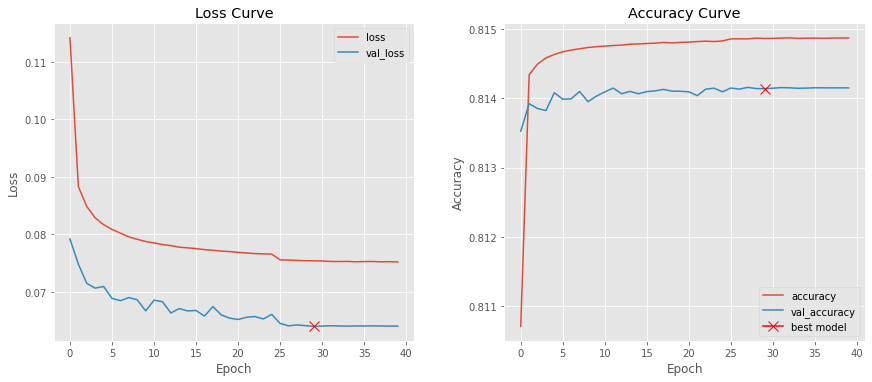

In [19]:
# === Use the Predefined Plotting Function === #
plot_learning( autoencoder_history )

## Reload the "Best" Autoencoder

Yet again, just like we did with the classifier, we want to load the most recent checkpoint for the autoencoder, which will contain the lowest validation loss (RMSE) of any training epoch observed. For the remainder of the notebook, this "best" model will be used for any autoencoder (encoding/decoding) operations. 

In [20]:
# === Load Most Recent Checkpoint === #
autoencoder.load_weights( 'autoencoder-model.h5' )

## Evaluate the Autoencoder

Now that we have reloaded the weights from the most successful checkpoint, we will yet again use the builtin `.evaluate()` function from keras to verify the performance of the loaded autoencoder. We evaluate the same metrics that were plotted during the learning curve (loss and accuracy, but again, accuracy is not that significant of a measure with the autoencoder, we are mostly concerned with achieving a near-zero loss). 

In [21]:
# === Evaluate the Model Against the Test Dataset === #
autoencoder.evaluate( X_test , X_test , verbose=True )

10000/10000 [==============================] - 1s 58us/sample - loss: 0.0640 - accuracy: 0.8141


[0.06398059453368186, 0.8141372]

## Separate Encoder from Decoder

The autoencoder itself may be neat, learning how to compress and reconstruct the image, but while the components are together like that, its uses are limited. What we are interested in is the two halves of the model. The encoder half (the first half of the model) which compresses the image down to a 7x7 representation, and the decoder half (second half) which reconstructs the original image when given the encoding. This is done by constructing two new models using the appropriate subset of layers from our autoencoder.

Though we know the exact layer number for the output of our encoder, I wrote this notebook in such a way that it will adjust dynamically to more complex models. First, we iterate the model layers of the autoencoder until we find the index of the layer names `"encoded"` (the expected output for the encoder -- the 7x7x1 shaped tensor in this example). 

We then partition out the encoder by constructing a new `keras.Sequential()` object, using all the first layers of the autoencoder through the layer with the extracted index (inclusive), and we `.build()` the newly constructed model, with an expected input shape that matches the autoencoder's input. 

Finally, we parse out the decoder half in a similar way, constructing another `keras.Sequential()` model given all layers of the autoencoder after the extracted index (through the final layer of the autoencoder). Once the object is constructed, we will build the decoder model by specifying the input shape of the decoder to be the same as the output shape of the encoder.

We print the `.summary()` output for both the encoder and decoder portions of the layers in order to verify that the model layers have been partitioned appropriately. 

In [22]:
# === Get Layer Index for End of Encoder === #
idx = 0
while autoencoder.layers[idx].name != 'encoded':
    idx += 1
    
# === Partition out the Encoder (First Half of Autoencoder) === #
print( 'Encoder:' )
encoder = keras.Sequential( layers=autoencoder.layers[:idx+1] )
encoder.build( input_shape=autoencoder.layers[0].input_shape )
encoder.summary( )

# === Partition out the Decoder (Second Half of Autoencoder) === #
print( '\n\nDecoder:' )
decoder = keras.Sequential( layers=autoencoder.layers[idx+1:] )
decoder.build( input_shape=encoder.layers[-1].output_shape )
decoder.summary( )

Encoder:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)

## Demonstrate the Autoencoder

Though conceptually the autoencoder is relatively straightforward, since it is working with neural networks, and has only been represented in terms of loss and accuracy values at the moment, some may still be skeptical as to the operations and effectiveness of the model. Because of this, we will demonstrate exactly what the autoencoder does (well... the encoder and the decoder separately). The custom function will select a random image of each digit in the given dataset (a random zero, a random one, etc.). Using the random image, we display three representations of that digit -- the original (unaltered) image, the result of encoding (output of the encoder model when given the image), and the reconstruction (the results of the decoder when given the encoding).

Interestingly enough, the encodings look like highly compressed representations of the same image (resized down to a $1/4$ scale), we cannot confirm that this will always be the case. The model simply "learned" what $7 \times 7$ image contains the most relevant information from the original image -- though JPEG compression and resizing may be more aesthetically pleasing, our model has decided that this compression is most useful for it learning to restore the original image. Out of the dozen practice runs of this notebook, it was observed once that the model learned to "invert" the image during encoding (resulting in black digits on a white background). Because MNIST is such a well-behaved dataset, the model is designed to maintain original proportions, and the convolutional nature of the autoencoder used (which maintains location proximity information), we find it is most common to still be able to "see the number".. albeit with difficulties. The decoded images are not perfect reconstructions, but as close of approximations as our models are capable of (if the loss was $0$, then the reconstructions would be perfect). 

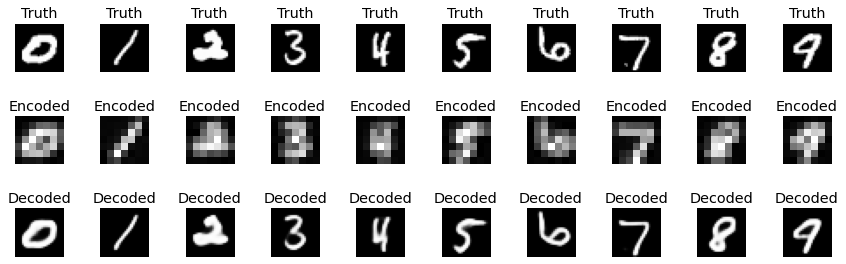

In [23]:
def demo_autoencoder( X , y , encoder , decoder ):
    
    # === Show the Images === #
    fig, ax = plt.subplots( nrows=3 , ncols=10 , figsize=(12,4) )
    fig.tight_layout( )
    
    # === Populate Axes === #
    for i in range( 10 ):
        
        # === Get a Random Image of Desired Class (Digit) === #
        idx = np.random.choice( np.where( y==i )[0] )
        
        # === Show the Ground Truth === #
        ax[0,i].imshow( X[idx] , cmap='gray' )
        ax[0,i].axis( 'off' )
        ax[0,i].title.set_text( 'Truth' )
        
        # === Show the Autoencoder Reconstruction === #
        encoded = encoder.predict( X[idx].reshape( (1,) + X[idx].shape ) )
        ax[1,i].imshow( encoded[0] , cmap='gray' )
        ax[1,i].axis( 'off' )
        ax[1,i].title.set_text( 'Encoded' )
        
        # === Show the Autoencoder Reconstruction === #
        decoded = decoder.predict( encoded )
        ax[2,i].imshow( decoded[0] , cmap='gray' )
        ax[2,i].axis( 'off' )
        ax[2,i].title.set_text( 'Decoded' )
        
    return

demo_autoencoder( X_test , y_test , encoder , decoder )

## Classifying the Encodings

The initial intent of this notebook is to demonstrate the impact on model performance and overhead. What we discovered so far is that the image dimensions could be reduced to $7\%$ the original size, which can greatly save on space and computation resources with larger datasets, allowing larger training batch sizes, faster training, allowing more of the data to reside in system memory at once, etc. 

But can our classifier keep up performance when looking at these highly pixilated images? some of them must be "too blurry" now -- we can see in the encodings how pixilated some of the numbers get, looking indistinguishable to us at times (is that an $8$ or a $5$? a $7$ or a $1$? a $4$ or a $9$?). Well that isn't a problem for our model. Remember, the autoencoder doesn't provide the most faithful represetation of the image in a visual sense, but it has learned how to encode the most information from the original image possible. Let's encode our training and validation images, and train the classifier again to recognize the encoded images instead. 

The following cell will convert all $70,000$ images in our MNIST dataset from the $28 \times 28 \times 1$ originals to the $7 \times 7 \times 1$ representations using our encoder. (the training dataset will be decreased from $60,000 \times 28 \times 28 \times 1= 47,040,000$ pixels down to $60,000 \times 7 \times 7 \times 1 = 2,940,000$ pixels, and the validation dataset will be decreased from $10,000 \times 28 \times 28 \times 1 = 7,840,000$ pixels down to $10,000 \times 7 \times 7 \times 1 = 490,000$ pixels). 

In [24]:
# === Encode the Training Data === #
print('Encoding Training Set...')
X_train_enc = encoder.predict( X_train , verbose=1 )

# === Encode the Validation Data === #
print('\nEncoding Testing Set...')
X_test_enc  = encoder.predict( X_test  , verbose=1 )

Encoding Training Set...
60000/60000 [==============================] - 2s 27us/sample

Encoding Testing Set...
10000/10000 [==============================] - 0s 28us/sample


## Reduction Effectiveness

Before we proceed, let's take a moment to verify the shape of the encoded dataset and report on how effective the reduction was (calculate and display the percent reduction in the number of pixels from the original image to the encoding). It is expected that the results should be encoded to a shape of $7 \times \7 = 49$ features or $93\%$ reduction in the number of features. 

In [25]:
# === Extract Encoded Dimension Metrics === #
h_enc = X_train_enc.shape[1]
w_enc = X_train_enc.shape[2]
a_enc = w_enc * h_enc
delta = int( abs( 100 * ( a_enc - a ) / ( a ) ) )

# === Report on Encoding === #
print( 'Encoded Shape: {} x {} --> {} features'.format( h_enc , w_enc , a_enc ) )
print( 'Percent-Reduction in Feature Space from {} to {} --> {}%'.format( a , a_enc , delta ) )

Encoded Shape: 7 x 7 --> 49 features
Percent-Reduction in Feature Space from 784 to 49 --> 93%


## Construct a New Classifier

We can't simply use the exact same classifier that we used for the unaltered images. That classifier was trained on the original dataset, not on the encodings. Additionally, the initial classifier was comstructed to expext the $28 \times 28 \times 1$ input shape; it will have errors for an unexpected input shape if you feed it the $7 \times 7 \times 1$ encoding. 

Instead, we will reuse the same `create_model()` function with the appropriate encoded image shape. This will create a convolutional neural network classifier with the same shape as the first classifier, but will be compatible with the new shape. We will compile the model to use the same optimizer and loss functions as the original classifier, and will report the model summary to show a successful construction. 

In [26]:
# === Create New CNN Classifier to Train on the Encodings Instead === #
encoded_model = create_model( X_train_enc[0].shape , 10 )
encoded_model.compile( optimizer='adam' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'] )
encoded_model.summary( )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 7, 7, 32)          320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 3, 3, 64)          256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 64)         

## Encoded Classifier Callbacks

We will use identical callbacks to the original classifier we constructed initially. The only difference is that we save our model checkpoints to a different file (in order to avoid overwriting the original classifier). We will use these callbacks to train the model constructed in the previous cell. 

In [27]:
encoded_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss' , mode='min' , patience=10 , verbose=1 ),
    keras.callbacks.ReduceLROnPlateau( factor=0.1 , patience=4 , min_lr=0.000001 , verbose=1 ),
    keras.callbacks.ModelCheckpoint( 'encoded-classifier-model.h5' , monitor='val_loss', mode='min' , verbose=1 , save_best_only=True , save_weights_only=True )
]

## Train the Encoding Classifier

Since we are using a new model designed to accept the encodings instead of the original images, we must train the model again to compare the effectiveness of this model against the original. We will train using an identical configuration as the original classifier in order to control for as many variable hyperparameters as possible -- the encoded dataset and their corresponding labels, a batch size of $32$, a maximum of $100$ epochs, and the callbacks defined in the previous cell. 

In [28]:
encoded_history = encoded_model.fit( X_train_enc, 
                                     y_train, 
                                     batch_size=32, 
                                     epochs=100, 
                                     callbacks=encoded_callbacks,
                                     validation_data=( X_test_enc , y_test ) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
59488/60000 [============================>.] - ETA: 0s - loss: 0.2852 - accuracy: 0.9116
Epoch 00001: val_loss improved from inf to 0.09852, saving model to encoded-classifier-model.h5
60000/60000 [==============================] - 6s 96us/sample - loss: 0.2840 - accuracy: 0.9119 - val_loss: 0.0985 - val_accuracy: 0.9708
Epoch 2/100
59744/60000 [============================>.] - ETA: 0s - loss: 0.1272 - accuracy: 0.9590
Epoch 00002: val_loss improved from 0.09852 to 0.07547, saving model to encoded-classifier-model.h5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.1272 - accuracy: 0.9590 - val_loss: 0.0755 - val_accuracy: 0.9764
Epoch 3/100
59776/60000 [============================>.] - ETA: 0s - loss: 0.1031 - accuracy: 0.9678
Epoch 00003: val_loss improved from 0.07547 to 0.06801, saving model to encoded-classifier-model.h5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.103

Epoch 27/100
59712/60000 [============================>.] - ETA: 0s - loss: 0.0266 - accuracy: 0.9910
Epoch 00027: val_loss improved from 0.03603 to 0.03589, saving model to encoded-classifier-model.h5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0265 - accuracy: 0.9910 - val_loss: 0.0359 - val_accuracy: 0.9888
Epoch 28/100
59648/60000 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9913
Epoch 00028: val_loss improved from 0.03589 to 0.03587, saving model to encoded-classifier-model.h5
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0256 - accuracy: 0.9913 - val_loss: 0.0359 - val_accuracy: 0.9880
Epoch 29/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9912
Epoch 00029: val_loss improved from 0.03587 to 0.03576, saving model to encoded-classifier-model.h5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.0252 - accuracy: 0.9912 - val_loss: 0.0358 - v

## Learning Curve

Just as we had with each of the other models, we will visualize the learning with our previously defined `plot_learning()` function to show a graph of the loss beside a graph of the accuracy while training the classifier. We should expect a similar curve to the other classifier with slightly different values. 

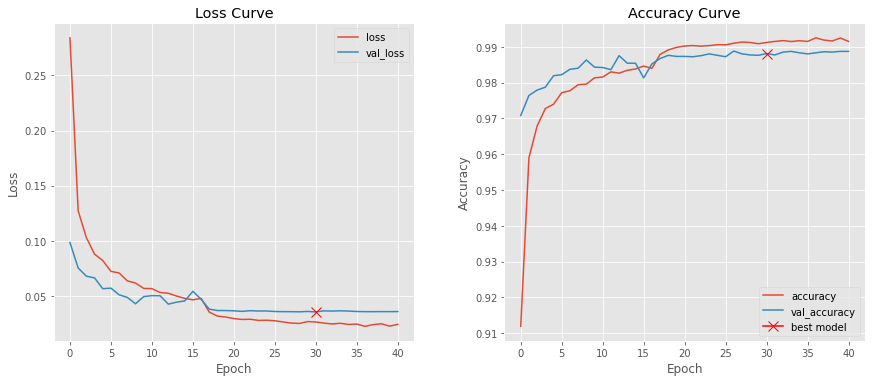

In [29]:
# === Use the Predefined Plotting Function === #
plot_learning( encoded_history )

## Load the "Best" Classifier

Again, repeating what we have done for the previous two models, we want to load the model weights from the most recent checkpoint in order to confirm that our classifier receives the "best" possible representation for it. We define best as the model which could achieve the lowest possible validation loss. 

In [30]:
# === Load Most Recent Checkpoint === #
encoded_model.load_weights( 'encoded-classifier-model.h5' )

## Evaluate the Classifier

In order to gain an understanding of the model performance for the checkpoint we used, we will evaluate it against the validation (test) dataset in order to report the validation loss and accuracy. If you are inclined to do so, these values should match the `val_loss` and `val_accuracy` of the final checkpoint reported in the training cell above. 

In [31]:
# === Evaluate the Model Against the Test Dataset === #
encoded_model.evaluate( X_test_enc , y_test , verbose=True )

10000/10000 [==============================] - 0s 42us/sample - loss: 0.0356 - accuracy: 0.9881


[0.035634417783812385, 0.9881]

## Demonstrate the Encoding Classifier

In the following code cell, a custom function is written for demonstrating the effectiveness of the classifier to those who may not be convinced by the raw loss and accuracy metrics. This demonstration will select a random image for each digit, display the image with the label "Original" and the true value of the digit, and the corresponding encoding with the label "Encoded" and the predicted value of the digit, as determined by the classifier. 

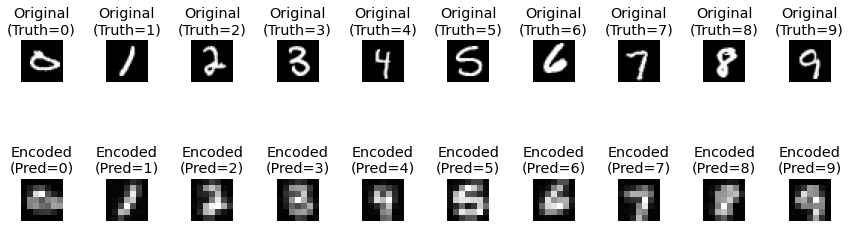

In [32]:
def demo_encoded_classifier( X , y , encoder , model ):
    
    # === Show the Images === #
    fig, ax = plt.subplots( nrows=2 , ncols=10 , figsize=(12,4) )
    fig.tight_layout( )
    
    # === Populate Axes === #
    for i in range( 10 ):
        
        # === Get a Random Image of Desired Class (Digit) === #
        idx = np.random.choice( np.where( y==i )[0] )
        
        # === Show the Ground Truth === #
        ax[0,i].imshow( X[idx] , cmap='gray' )
        ax[0,i].axis( 'off' )
        ax[0,i].title.set_text( 'Original\n(Truth={})'.format( y[idx] ) )
        
        # === Show the Autoencoder Reconstruction === #
        encoded = encoder.predict( X[idx].reshape( (1,) + X[idx].shape ) )
        ax[1,i].imshow( encoded[0] , cmap='gray' )
        ax[1,i].axis( 'off' )
        ax[1,i].title.set_text( 'Encoded\n(Pred={})'.format(np.argmax(model.predict(encoded))) )
        
    # === Show Figure === #
    return

demo_encoded_classifier( X_test , y_test , encoder , encoded_model )

## Confusion Matrix

Just like the original classifier, we will use the `show_confusion_matrix()` function defined previously to demonstrate the confusion matrix for anyone inclined to compare the representations to see which proportions of classifications were incorrect in the test set, and what proportion of each class were predicted as each other class. 

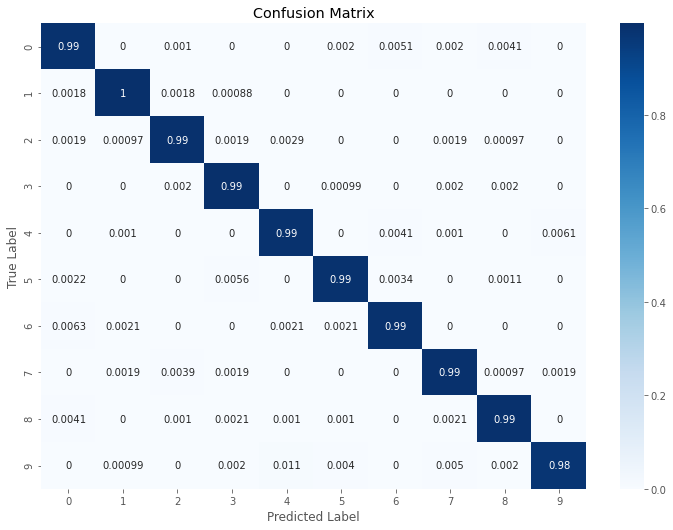

In [33]:
show_confusion_matrix( X_test_enc , y_test , encoded_model )

## Comparing the Classifiers

We know how the change in dataset dimensions worked (this impact mostly affects fully-connected "dense" layers of the networks). Let's now report on the pentalties to validation loss/accuracy in order to evaluate the effectiveness of using an autoencoder, the tradeoffs aroudn these penalties, and any additional conclusions.

We see that there is a small accuracy penalty (the exact value varies depending on the runtime circumstances), of approximately a $0.5\%$ reduction in the accuracy when using the encoding. Less than a full percent reduction from ~$99.2\%$  to ~$98.7\%$. This results in a ~$0.5\%$ penalty in accuracy for using the encoder versus the original. The validation loss sees an increase from ~$0.03$ to ~$0.04$, which is small in value, but it is a ~$25\%$ increase (penalty) in the loss of the model when considering values this small. 

The model is still extremely good, but we do see that it underperforms compared to the original. With small, well-behaved datasets like MNIST, it may be effective to use either model, but there is a time-cost in performance that we must consider when using dense neural networks instead of convolutional ones. Dense neural networks rely much more heavily on input shape in order to determine the number of features the model must learn (which affects the file size, system memory requirements, GPU memory requirements, computation power required to train, and runtime overhead of training/using the model). Another notebook will be used for demonstrating this same use case with dense neural networks instead of convolutional neural networks. 

In [34]:
# === Get the Metrics === #
raw_loss , raw_acc = raw_model.evaluate( X_test , y_test , verbose=False )
enc_loss , enc_acc = encoded_model.evaluate( X_test_enc , y_test , verbose=False )

# === Compute the Percentage Changes === #
acc_change  = ( enc_acc - raw_acc ) / raw_acc
loss_change = ( enc_loss - raw_loss ) / raw_loss

# === Report Accuracy Comparisons === #
print( 'ACCURACY: (higher=better)' )
print( 'Test Accuracy Without Autoencoder:  {:.2f}%'.format( 100 * raw_acc ) )
print( 'Test Accuracy With the Autoencoder: {:.2f}%'.format( 100 * enc_acc ) )
print( 'Total Accuracy Penalty: {:.4f}'.format( abs( raw_acc - enc_acc ) ) )
print( 'Percent Change in Accuracy: {:.2f}%'.format( 100 * acc_change ) )
print( '' )

# === Report Loss Comparisons === #
print( 'LOSS: (lower=better)' )
print( 'Test Loss Without Autoencoder:  {:.4f}'.format( raw_loss ) )
print( 'Test Loss With the Autoencoder: {:.4f}'.format( enc_loss ) )
print( 'Total Loss Penalty: {:.4f}'.format( abs( raw_loss - enc_loss ) ) )
print( 'Percent Change in Loss: {:.2f}%'.format( 100 * loss_change ) )

ACCURACY: (higher=better)
Test Accuracy Without Autoencoder:  99.22%
Test Accuracy With the Autoencoder: 98.81%
Total Accuracy Penalty: 0.0041
Percent Change in Accuracy: -0.41%

LOSS: (lower=better)
Test Loss Without Autoencoder:  0.0295
Test Loss With the Autoencoder: 0.0356
Total Loss Penalty: 0.0062
Percent Change in Loss: 20.88%
